### Purpose: inital eda/modeling of web scraped New York City property data to explore Zillow's 'Zestimate' and 'sellingSoon' params
### Note: This was a naive/initial attempt to run some models once I had scraped enough data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
import logging
import warnings
warnings.filterwarnings('ignore')

logger = logging.getLogger()
file_handler = logging.FileHandler(filename='models.log', mode='a')
logger.addHandler(file_handler)
logger.setLevel(logging.INFO)

import plotly.graph_objects as go
import plotly.subplots as sp
import matplotlib.pyplot as plt
import io
import plotly.io as pio
pio.templates.default = 'plotly_dark'

def plot_model_predictions(y_test, y_pred, title):
    fig = go.Scatter(x=y_test, y=y_pred, mode='markers', marker_line_color='green', marker_line_width=1)
    layout = go.Layout(title=title, xaxis_title="Actual", yaxis_title="Predictions", )
    fig = go.Figure(data=[fig], layout=layout)
    return fig

def plot_feature_importance(model, X, title):
    importances = model.feature_importances_
    feature_names = [f.split('.')[-1] for f in X.columns]
    features = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
    features = [f for f in features if f[1] > 0.002]  # Keep features with importance > 0.002
    feature_names, feature_importance_vals = zip(*features)
    fig = go.Bar(x=feature_names, y=feature_importance_vals)
    layout = go.Layout(title=title, xaxis_title="Feature", yaxis_title="Importance", xaxis_tickangle=-45, title_x=0.5, title_font_size=20)
    fig = go.Figure(data=[fig], layout=layout)
    return fig

def stack_plots(fig_scatter, fig_imp, model_name, mae, r2):
    parent_fig = sp.make_subplots(rows=2, cols=1)
    parent_fig.add_trace(fig_scatter.data[0], row=1, col=1)
    parent_fig.update_xaxes(title_text="Actual", row=1, col=1)
    parent_fig.update_yaxes(title_text="Predictions", row=1, col=1)
    parent_fig.add_trace(fig_imp.data[0], row=2, col=1)
    parent_fig.update_xaxes(title_text="Feature", row=2, col=1)
    parent_fig.update_yaxes(title_text="Importance", row=2, col=1)
    parent_fig.update_layout(title_text=f'{model_name} \nMAE: {mae:.2f} R2: {r2:.3f}', title_x=0.5, title_font_size=20)
    return parent_fig

In [ ]:
# Load and preprocess data
df_path = 's3://general-scratch/alt_data/nyc_zestimate_regression.csv'
df = pd.read_csv(df_path)

features = [
    'root.property.overview.price',
    'root.property.pricing.mortgageZHLRates.arm5Bucket.rate',
    'root.property.propertyFeatures.homeType',
    'root.property.pricing.propertyTaxRate',
    'root.property.propertyFeatures.hasGarage',
    'root.property.propertyFeatures.parkingCapacity',
    'root.property.overview.favoriteCount',
    'root.property.overview.pageViewCount',
    'root.property.overview.daysOnZillow',
    'root.property.propertyFeatures.hasHeating',
    'root.property.overview.propertyTaxRate',
    'root.property.location.latitude',
    'root.property.propertyFeatures.bedrooms',
    'root.property.overview.yearBuilt',
    'root.property.location.zipcode',
    'root.property.location.longitude',
    'root.property.propertyFeatures.bathroomsFloat',
    'root.property.propertyFeatures.hoaFee',
    'avgPriceChange',
    'avgSchoolRating',
    'root.property.pricing.zestimate',
    'sellingSoon'
]
df_regress = df[features].dropna()

df_regress['root.property.propertyFeatures.hasHeating'] = df_regress['root.property.propertyFeatures.hasHeating'].astype(bool)
df_regress['root.property.propertyFeatures.hasGarage'] = df_regress['root.property.propertyFeatures.hasGarage'].astype(bool)
df_regress['root.property.propertyFeatures.homeType'] = df_regress['root.property.propertyFeatures.homeType'].astype('category')
df_regress['avgSchoolRating'] = df_regress['avgSchoolRating'].round(0).astype(int)
df_regress['root.property.pricing.propertyTaxRate'] = df_regress['root.property.pricing.propertyTaxRate'].replace(0, df_regress['root.property.pricing.propertyTaxRate'].mean())

encoding_req_features = [
    'root.property.propertyFeatures.homeType',
    'root.property.propertyFeatures.hasHeating',
    'root.property.propertyFeatures.hasGarage',
    'root.property.location.zipcode',
    'root.property.pricing.mortgageZHLRates.arm5Bucket.rate',
    'root.property.pricing.propertyTaxRate',
]

df_continous = df_regress.copy().drop(columns=encoding_req_features)
encode_features_df = df_regress.copy()[encoding_req_features]
encode_array = encode_features_df.values
le = preprocessing.LabelEncoder()
for i in range(len(encode_features_df.columns)):
    encode_array[:, i] = le.fit_transform(encode_array[:, i])
encoded_df = pd.DataFrame(encode_array, columns=encoding_req_features)

preprocessed_df = pd.concat([df_continous, encoded_df], axis=1).dropna()
preprocessed_df = preprocessed_df[preprocessed_df['root.property.overview.price'] < 40000000]

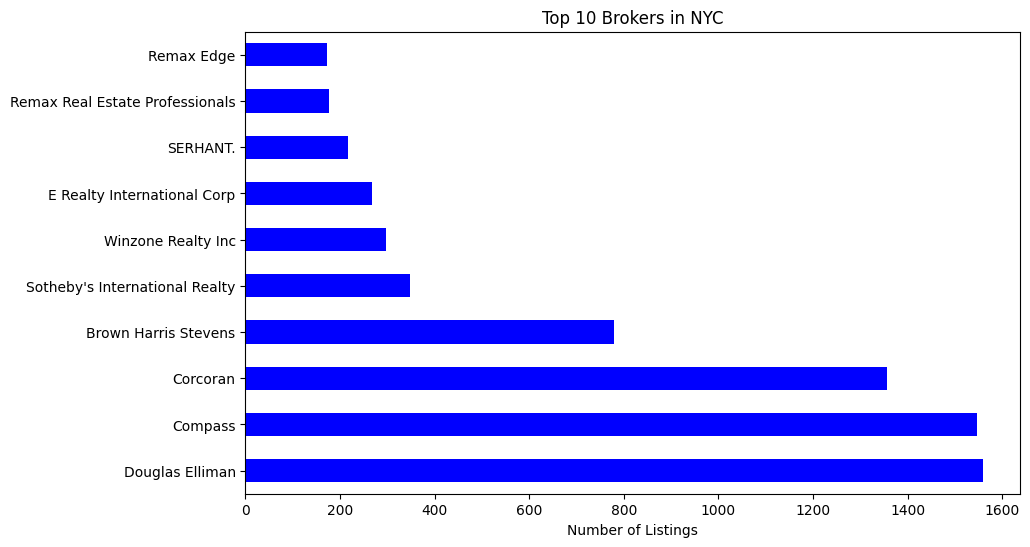

In [ ]:
# plot a graph of the top 10 brokeages, no relevance, just interested
import matplotlib.pyplot as plt
import seaborn as sns

brokerage[:10].plot(kind='barh', figsize=(10,6), color='blue')
plt.xlabel('Number of Listings')
plt.title('Top 10 Brokers in NYC')
plt.show()

In [ ]:
# Modeling 'Zestimate' Parameter
price_rem = preprocessed_df.drop(columns=['root.property.overview.price'])
X = price_rem.drop(columns=['root.property.pricing.zestimate'])
y = price_rem['root.property.pricing.zestimate']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(**params)
gbr.fit(X_train2, y_train2)
ypred2 = gbr.predict(X_test2)
mse = mean_squared_error(y_test2, ypred2)
mae = np.mean(np.abs(ypred2 - y_test2))
r2 = r2_score(y_test2, ypred2)
model_name = 'Gradient Boosted Trees: Zestimate: Price Parameter Removed'
print(model_name)
print('MSE: ', mse)
print('MAE: ', mae)
print('R2: ', r2)
logging.info(f'\n-{model_name}- \nMAE: {mae:.3f} MSE: {mse:.3f} R2: {r2:.3f} Params: {params}')

fig = plot_model_predictions(y_test2, ypred2, 'Predictions: Gradient Boosted Trees: Zestimate. Price Parameter Dropped')
fig_imp = plot_feature_importance(gbr, X, 'Feature Importances: Gradient Boosted Trees: Zestimate. Price Parameter Dropped')
fig = stack_plots(fig, fig_imp, model_name, mae, r2)
fig.show()

Gradient Boosted Trees: Zestimate: Price Parameter Removed
MSE:  1313319017386.6045
MAE:  360242.6399806085
R2:  0.8539604784813927


In [ ]:
# Linear Regression for 'Zestimate'
X = preprocessed_df.drop(columns=['root.property.pricing.zestimate', 'root.property.location.latitude', 'root.property.location.longitude'])
y = preprocessed_df['root.property.pricing.zestimate']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LinearRegression()
lr.fit(X_train2, y_train2)
ypred2 = lr.predict(X_test2)
mse = mean_squared_error(y_test2, ypred2)
mae = np.mean(np.abs(ypred2 - y_test2))
r2 = r2_score(y_test2, ypred2)

model_name = 'LR: Zestimate WITHOUT Price Column Dropped (under 4m)'
print(model_name)
print(f'MSE: {mse:.0f}')
print(f'MAE: {mae:.0f}')
print(f'R2: {r2:.4f}')
logging.info(f'\n-{model_name}- \nMAE: {mae:.3f} MSE: {mse:.3f} R2: {r2:.3f}')

fig3 = plot_model_predictions(y_test2, ypred2, 'Predictions: LR: Zestimate: Price Parameter Dropped')
feature_importances = pd.DataFrame(lr.coef_, index=X_train2.columns, columns=['importance']).sort_values('importance', ascending=False).round(3)
feature_importances = feature_importances[feature_importances['importance'] > 0]
feature_names = [f.split('.')[-1] for f in list(feature_importances.index)]
fig_importance_reg = go.Bar(x=feature_names, y=feature_importances['importance'])
layout = go.Layout(title='Feature Importance', xaxis_title="Feature", yaxis_title="Importance", xaxis_tickangle=-45, title_x=0.5, title_font_size=20)
fig = go.Figure(data=[fig_importance_reg], layout=layout)
fig = stack_plots(fig3, fig, model_name, mae, r2)
fig.show()

LR: Zestimate WITHOUT Price Column Dropped (under 4m)
MSE: 421126054617
MAE: 84690
R2: 0.9532


In [ ]:
# GBR for Listing Price (without Zestimate)
X = preprocessed_df.drop(columns=['root.property.overview.price', 'root.property.pricing.zestimate'])
y = preprocessed_df['root.property.overview.price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(**params)
gbr.fit(X_train, y_train)
ypred = gbr.predict(X_test)
mse = mean_squared_error(y_test, ypred)
mae = np.mean(np.abs(ypred - y_test))
r2 = r2_score(y_test, ypred)
model_name = 'GBR: Listing Price (without Zestimate)'
model_info = f'\n-{model_name}- \nMAE: {mae:.3f} MSE: {mse:.3f} R2: {r2:.3f} Params: {params}'
print(model_info)
logging.info(model_info)

fig_scatter = plot_model_predictions(y_test, ypred, 'Predictions: Gradient Boosted Trees: Listing Price (without Zestimate)')
fig_imp = plot_feature_importance(gbr, X, 'Feature Importances: Gradient Boosted Trees: Listing Price (without Zestimate)')
fig = stack_plots(fig_scatter, fig_imp, model_name, mae, r2)
fig.show()


-GBR: Listing Price (without Zestimate)- 
MAE: 354415.207 MSE: 1203034167508.561 R2: 0.883 Params: {'n_estimators': 600, 'max_depth': 5, 'learning_rate': 0.01, 'min_samples_split': 3}


In [ ]:
# Linear Regression for Listing Price (without Zestimate)
X = preprocessed_df.drop(columns=['root.property.overview.price', 'root.property.pricing.zestimate'])
y = preprocessed_df['root.property.overview.price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
ypred = lr.predict(X_test)
mse = mean_squared_error(y_test, ypred)
mae = np.mean(np.abs(ypred - y_test))
r2 = r2_score(y_test, ypred)
model_name = 'LR: Listing Price (without Zestimate)'
model_info = f'\n-{model_name}- \nMAE: {mae:.3f} MSE: {mse:.3f} R2: {r2:.3f}'
print(model_info)
logging.info(model_info)

fig_scatter = plot_model_predictions(y_test, ypred, 'LR: Listing Price (without Zestimate)')
feature_importances = pd.DataFrame(lr.coef_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False).round(3)
feature_importances = feature_importances[feature_importances['importance'] > 0]
feature_names = [f.split('.')[-1] for f in list(feature_importances.index)]
fig = go.Bar(x=feature_names, y=feature_importances['importance'], )
layout = go.Layout(title='Feature Importance', xaxis_title="Feature", yaxis_title="Importance", xaxis_tickangle=-45, title_x=0.5, title_font_size=20)
fig = go.Figure(data=[fig], layout=layout)
fig.show()


-LR: Listing Price (without Zestimate)- 
MAE: 1142433.474 MSE: 5324693477909.921 R2: 0.482


In [ ]:
# Modeling 'sellingSoon' Parameter
X_encoded = preprocessed_df.drop(columns=['sellingSoon'])
y_encoded = preprocessed_df['sellingSoon']
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

params = {
    'n_estimators': 600,
    'max_depth': 5,
    'learning_rate': 0.01,
    'min_samples_split': 3,
}
gbr = GradientBoostingRegressor(**params)
gbr.fit(X_train, y_train)
ypred = gbr.predict(X_test)
mse = mean_squared_error(y_test, ypred)
mae = np.mean(np.abs(ypred - y_test))
r2 = r2_score(y_test, ypred)
model_name = 'GBR: sellingSoon'
model_info = f'\n-{model_name}- \nMAE: {mae:.3f} MSE: {mse:.3f} R2: {r2:.3f} Params: {params}'
print(model_info)
logger.info(model_info)

fig_sct = plot_model_predictions(y_test, ypred, 'Predictions: Gradient Boosted Trees: sellingSoon')
fig_imp = plot_feature_importance(gbr, X_encoded, 'Feature Importances: Gradient Boosted Trees: sellingSoon')
fig = stack_plots(fig_sct, fig_imp, model_name, mae, r2)
fig.show()


-GBR: sellingSoon- 
MAE: 0.052 MSE: 0.005 R2: 0.945 Params: {'n_estimators': 600, 'max_depth': 5, 'learning_rate': 0.01, 'min_samples_split': 3}


In [ ]:
# SellingSoon param without daysOnZillow
X_encoded = preprocessed_df.drop(columns=['sellingSoon'])
X_encoded = X_encoded.drop(columns=['root.property.overview.daysOnZillow'])
y_encoded = preprocessed_df['sellingSoon']
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

params = {
    'n_estimators': 600,
    'max_depth': 5,
    'learning_rate': 0.01,
    'min_samples_split': 3,
}
gbr = GradientBoostingRegressor(**params)
gbr.fit(X_train, y_train)
ypred = gbr.predict(X_test)
mse = mean_squared_error(y_test, ypred)
mae = np.mean(np.abs(ypred - y_test))
r2 = r2_score(y_test, ypred)
model_name = 'GBR: sellingSoon'
model_info = f'\n-{model_name}- \nMAE: {mae:.3f} MSE: {mse:.3f} R2: {r2:.3f} Params: {params}'
print(model_info)
logger.info(model_info)

fig_sct = plot_model_predictions(y_test, ypred, 'Predictions: Gradient Boosted Trees: sellingSoon')
fig_imp = plot_feature_importance(gbr, X_encoded, 'Feature Importances: Gradient Boosted Trees: sellingSoon')
fig = stack_plots(fig_sct, fig_imp, model_name, mae, r2)
fig.show()


-GBR: sellingSoon- 
MAE: 0.204 MSE: 0.056 R2: 0.358 Params: {'n_estimators': 600, 'max_depth': 5, 'learning_rate': 0.01, 'min_samples_split': 3}
